In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/home/tal/docker/dockvenv/bin/python3


(256, 160)


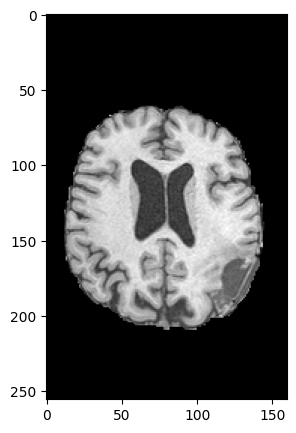

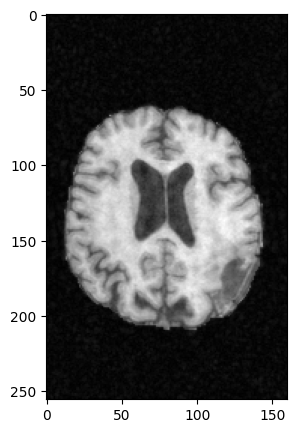

0.507177734375


In [4]:
da = h5py.File("../..//single_channel_data/test/training_set_16.h5", 'r')
kspace = np.array(da["kspace"])[21,...]
target = np.array(da["reconstruction"])[21,...]
reference = np.array(da["reconstruction"])[22,...]
reference_kspace = np.array(da["kspace"])[22,...]
mask2 = sp.mri.poisson((640,372), 4, calib=(70, 56), dtype=float, crop_corner=False, return_density=False, seed=0, max_attempts=6, tol=0.1)
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)

# Path to your NIfTI file
nii_file_target = './test_data/T1_week28reg.nii'
img_target = nib.load(nii_file_target)
nii_file_ref = './test_data/T1_week40regT1_week28.nii'
img_ref = nib.load(nii_file_ref)
target = img_target.get_fdata()[...,25]
reference = img_ref.get_fdata()[...,25]
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float() 
reference_kspace_torch = T.fft2(reference_torch)
reference_kspace= cplx.to_numpy(reference_kspace_torch)
kspace_torch = T.fft2(target_torch)
kspace = cplx.to_numpy(kspace_torch)
# Print the shape of the data to verify
print(target.shape)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(target), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.show()
mask2 = sp.mri.poisson((256,160), 2, calib=(30, 22), dtype=float, crop_corner=False, return_density=False, seed=0, max_attempts=6, tol=0.1)
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)
#kspace_torch = T.awgn(kspace_torch,15,L=1)
kspace_torch = kspace_torch*mask_torch
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(cplx.to_numpy(T.ifft2(kspace_torch))), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.show()

s = 256*160
print(np.sum(mask2)/s)


0.507177734375


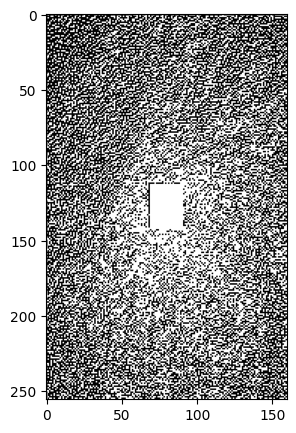

"\nfig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns\n# Plot each image in a subplot\nim1 = axs[0].imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')\naxs[0].set_title('Input')\nfig.colorbar(im1, ax=axs[0])\nim2 = axs[1].imshow(np.flipud(np.abs(mask_torch)), cmap='gray')\naxs[1].set_title('Output')\nfig.colorbar(im2, ax=axs[1])\nim3 = axs[2].imshow(np.log(np.abs(cplx.to_numpy(T.fft2(target_torch)))), cmap='gray')\naxs[2].set_title('Target')\nfig.colorbar(im3, ax=axs[2])\nplt.tight_layout()\nplt.show()\n\nfig, axs = plt.subplots(1, 1, figsize=(20,10))  # 1 row, 3 columns\n# Plot each image in a subplot\nim1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')\naxs.set_title('Input')\nfig.colorbar(im1, ax=axs)\nplt.show()\n"

In [5]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(256,24)),(256,160))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
#kspace_torch = T.awgn(kspace_torch,15,L=1)   
target_torch = cplx.to_tensor(target).float()

""" 
mask_slice = np.ones((256,160))
mask_func = MaskFunc([0.08],[4])
mk1 = mask_func((1,1,160,2))[0,0,:,0]
mk2 = mask_func((1,1,256,2))[0,0,:,0]
#knee_masks = mask_slice*mk1*(mk2[:, np.newaxis])
knee_masks = mask_slice*mk1
mask_torch = torch.tensor(knee_masks[...,None]).float()
mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)
kspace_goal = kspace_torch  
kspace_torch = kspace_torch*mask_torch
""" 
### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(256,24)),(256,160))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()

s = 256*160
print(np.sum(mask2)/s)
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(mask2, cmap='gray')
plt.show()
kspace_torch = kspace_torch*mask_torch

"""
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs[0].imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(mask_torch)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.log(np.abs(cplx.to_numpy(T.fft2(target_torch)))), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20,10))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
axs.set_title('Input')
fig.colorbar(im1, ax=axs)
plt.show()
"""


In [6]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [8]:
#checkpoint_file = "./L2_checkpoints_poisson_x4_refisinput/model_9.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_ref/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_reflong/model_80.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_noref/model_35.pt" # SA test - 32PSNR
checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolled/model_30.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_test3/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_refnewarch/model_30.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_test2/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_refarchsig/model_30.pt"

checkpoint = torch.load(checkpoint_file,map_location=device)

In [9]:
params = checkpoint["params"]
#single_MoDL = UnrolledModel(params).to(device)
#single_MoDL = MyNetwork(2,2).to(device)
single_MoDL = Unrolled(params).to(device)
single_MoDL.load_state_dict(checkpoint['model'])

shared weights


<All keys matched successfully>

In [10]:
kspace_torch.shape
reference_torch.shape

torch.Size([256, 160, 2])

In [11]:
with torch.no_grad():
    kspace_torch = kspace_torch.unsqueeze(0).to(device)
    mask_torch = mask_torch.unsqueeze(0).to(device)
    reference_torch = reference_torch.unsqueeze(0).to(device)
    im_out = single_MoDL(kspace_torch.float(),reference_torch,mask=mask_torch)

In [12]:

#pl.ImagePlot(cplx.to_numpy(T.ifft2(kspace_torch.cpu())))
#pl.ImagePlot(np.log(np.abs(cplx.to_numpy(kspace_torch.cpu()))).squeeze(0))

In [13]:
#pl.ImagePlot(cplx.to_numpy(target_torch.cpu()))
#pl.ImagePlot(np.log(np.abs(cplx.to_numpy(T.fft2(target_torch.cpu())))))

In [14]:
#pl.ImagePlot(cplx.to_numpy(im_out.cpu()))
#pl.ImagePlot(np.log(np.abs(cplx.to_numpy(T.fft2(im_out.cpu())))))

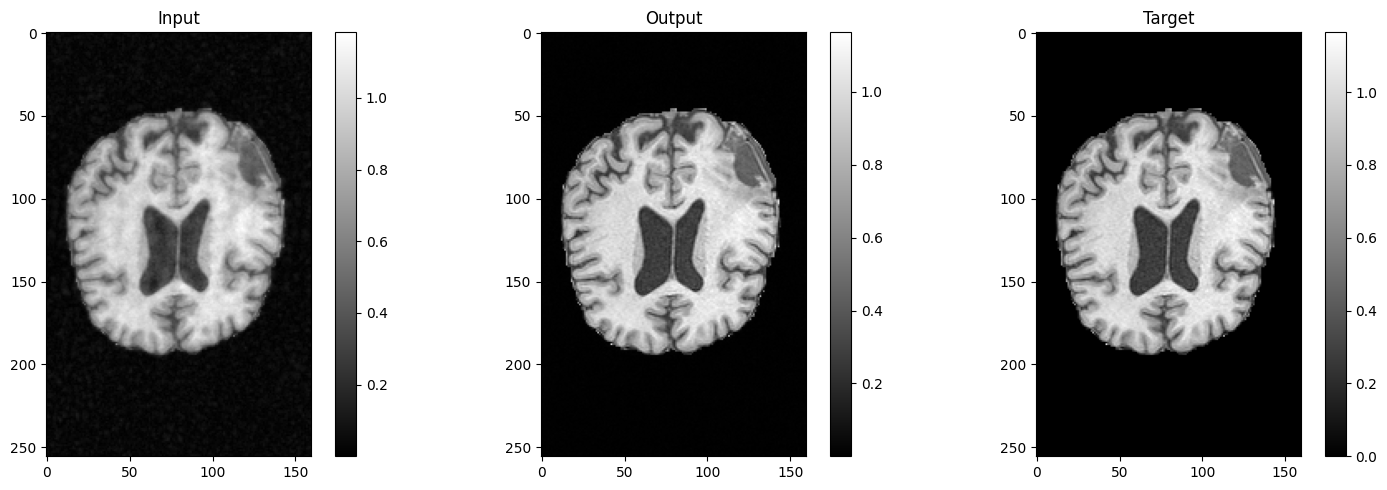

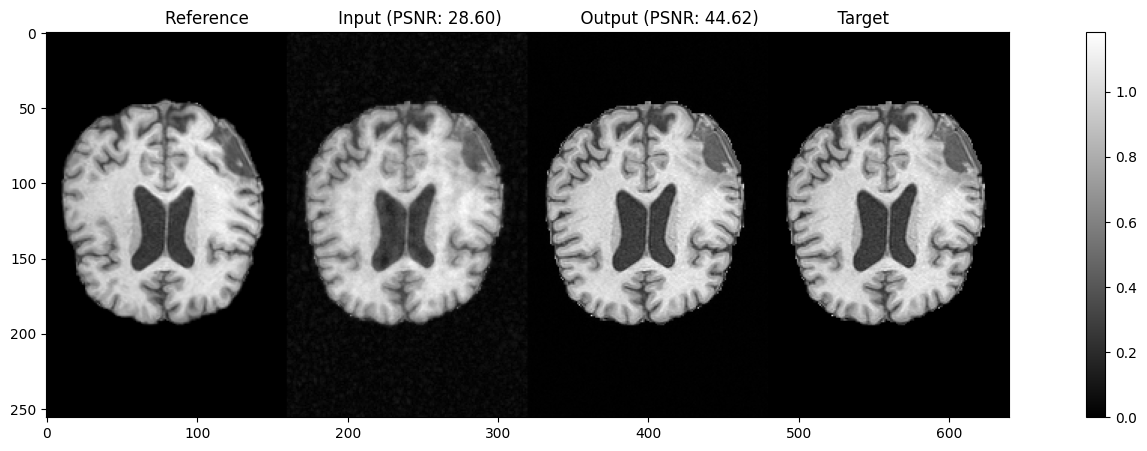

In [15]:
cplx_image_target = cplx.to_numpy(target_torch.cpu())
cplx_image_in = cplx.to_numpy(T.ifft2(kspace_torch.cpu())).squeeze(0)
cplx_image_out = cplx.to_numpy(im_out.cpu()).squeeze(0)
cplx_image_reference = cplx.to_numpy(reference_torch.cpu()).squeeze(0)

psnr_in = T.PSNR(target_torch.cpu(), T.ifft2(kspace_torch.cpu())).item()
psnr_out = T.PSNR(target_torch.cpu(), im_out.cpu()).item()
# Create a figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each image in a subplot
im1 = axs[0].imshow(np.flipud(np.abs(cplx_image_in)), cmap='gray')
axs[0].set_title('Input')
fig.colorbar(im1, ax=axs[0])
im2 = axs[1].imshow(np.flipud(np.abs(cplx_image_out)), cmap='gray')
axs[1].set_title('Output')
fig.colorbar(im2, ax=axs[1])
im3 = axs[2].imshow(np.flipud(np.abs(cplx_image_target)), cmap='gray')
axs[2].set_title('Target')
fig.colorbar(im3, ax=axs[2])
plt.tight_layout()
plt.show()

plt_concat = np.concatenate((np.flipud(np.abs(cplx_image_reference)),np.flipud(np.abs(cplx_image_in)),np.flipud(np.abs(cplx_image_out)),np.flipud(np.abs(cplx_image_target))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
axs.set_title(f'Reference                 Input (PSNR: {psnr_in:.2f})               Output (PSNR: {psnr_out:.2f})               Target')

fig.colorbar(im, ax=axs)
plt.show()




(256, 160)
(256, 160)
(256, 160)


/tmp/ipykernel_230384/1762163145.py:11: RuntimeWarning: divide by zero encountered in log
  im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')


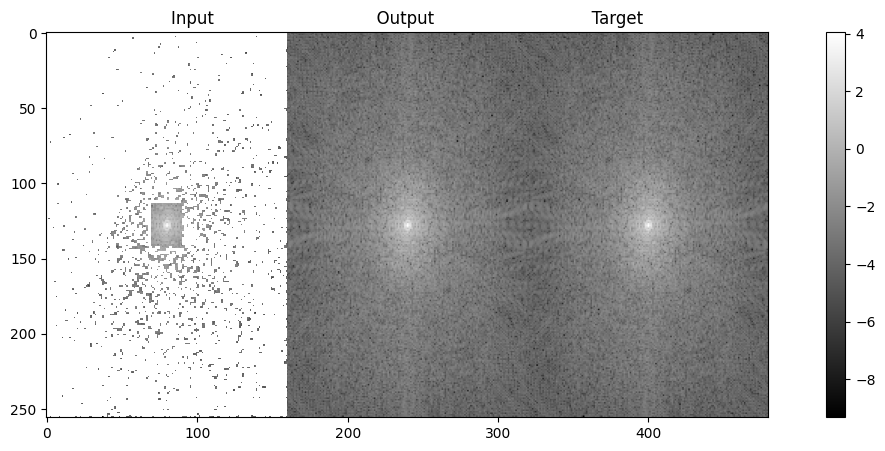

/tmp/ipykernel_230384/1762163145.py:16: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))


/home/tal/.local/lib/python3.10/site-packages/matplotlib/image.py:453: RuntimeWarning: invalid value encountered in double_scalars
  vmid = np.float64(self.norm.vmin) + dv / 2


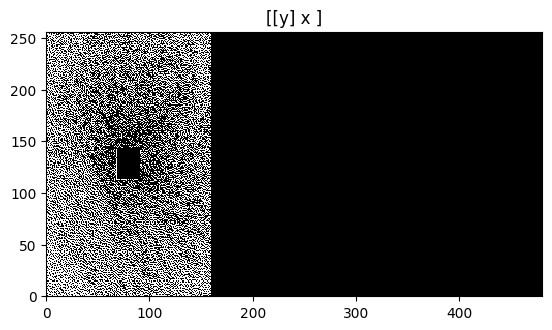

In [16]:
cplx_image_target = np.abs(cplx.to_numpy(T.fft2(target_torch.cpu())))
cplx_image_in = np.abs(cplx.to_numpy(kspace_torch.cpu()).squeeze(0))
cplx_image_out = np.abs(cplx.to_numpy(T.fft2(im_out.cpu())).squeeze(0))
print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes

plt_concat = np.concatenate((cplx_image_in,cplx_image_out,cplx_image_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))

In [17]:
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float
import ut
####### Errors calculation #######

# Assuming img1 and img2 are PIL images or numpy arrays
# Convert PIL images to numpy arrays if needed
img_target = img_as_float(np.abs(cplx_image_target).copy())/np.max(np.abs(cplx_image_target))
img_in = img_as_float(np.abs(cplx_image_in)/np.max(cplx_image_in))/np.max(np.abs(cplx_image_in))
img_out = img_as_float(np.abs(cplx_image_out).copy())/np.max(np.abs(cplx_image_out))
img_reference = img_as_float(np.abs(cplx_image_reference).copy())/np.max(np.abs(cplx_image_reference))

####### Errors calculation #######

print(f'MSE input: {np.mean(np.abs(cplx_image_in-cplx_image_target)**2)}')
print(f'MSE output: {np.mean(np.abs(cplx_image_out-cplx_image_target)**2)}')

print(f'PSNR input: {T.PSNR(target_torch.cpu(), T.ifft2(kspace_torch.cpu()))}')
print(f'PSNR output: {T.PSNR(target_torch.cpu(), im_out.cpu())}')

# Calculate SSIM values
data_range = img_target.max() - img_target.min()
ssim_in, _ = ssim(img_target, img_in, data_range=data_range, full=True)
ssim_out, _ = ssim(img_target, img_out, data_range=data_range, full=True)

print(f"SSIM input: {ssim_in:.4f}")
print(f"SSIM output: {ssim_out:.4f}")


MSE input: 0.0027587823569774628
MSE output: 4.3941101466771215e-05
PSNR input: tensor([28.6031])
PSNR output: tensor([44.6168])
SSIM input: 0.9721
SSIM output: 1.0000
